# 7. Implementing an autoregressive Seq2Seq model

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (05/03/2024)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Torch (tested on v2.0.1+cu118)

In [116]:
import pandas as pd

# Relative path to the CSV
csv_path = '../dataset/train/DailyDelhiClimateTrain.csv'

# Load the dataset
df_train = pd.read_csv(csv_path)

# Quick look at the data
print(df_train.head())


         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000


In [117]:
df_train[:15]

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


In [118]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Load the multivariate CSV
df = pd.read_csv('../dataset/train/DailyDelhiClimateTrain.csv')

# Drop the 'date' column and convert the rest to numpy
data = df.drop(columns=['date']).values.astype(np.float32)

# Sequence and future steps
seq_length = 90
future_steps = 90  # 5 steps

torch.set_printoptions(precision=4, sci_mode=False)

# Custom Dataset
class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, future_steps):
        self.data = data
        self.seq_length = seq_length
        self.future_steps = future_steps

    def __len__(self):
        # Must have enough room for input + future
        return len(self.data) - self.seq_length - self.future_steps + 1

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_length]
        y = self.data[idx + self.seq_length : idx + self.seq_length + self.future_steps]
        return torch.tensor(x).float(), torch.tensor(y).float()

# Create dataset and dataloader
dataset = MultivariateTimeSeriesDataset(data, seq_length, future_steps)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Visualize a sample
sample = next(iter(dataloader))
input_sample, output_sample = sample
print("Input shape:", input_sample.shape)   # [64, 10, 4]
print("Output shape:", output_sample.shape) # [64, 5, 4]


Input shape: torch.Size([64, 90, 4])
Output shape: torch.Size([64, 90, 4])


In [119]:
dataset[0]

(tensor([[   10.0000,    84.5000,     0.0000,  1015.6667],
         [    7.4000,    92.0000,     2.9800,  1017.8000],
         [    7.1667,    87.0000,     4.6333,  1018.6667],
         [    8.6667,    71.3333,     1.2333,  1017.1667],
         [    6.0000,    86.8333,     3.7000,  1016.5000],
         [    7.0000,    82.8000,     1.4800,  1018.0000],
         [    7.0000,    78.6000,     6.3000,  1020.0000],
         [    8.8571,    63.7143,     7.1429,  1018.7143],
         [   14.0000,    51.2500,    12.5000,  1017.0000],
         [   11.0000,    62.0000,     7.4000,  1015.6667],
         [   15.7143,    51.2857,    10.5714,  1016.1429],
         [   14.0000,    74.0000,    13.2286,  1015.5714],
         [   15.8333,    75.1667,     4.6333,  1013.3333],
         [   12.8333,    88.1667,     0.6167,  1015.1667],
         [   14.7143,    71.8571,     0.5286,  1015.8571],
         [   13.8333,    86.6667,     0.0000,  1016.6667],
         [   16.5000,    80.8333,     5.2500,  1015.8333

### Imports and CUDA

### Our encoder model

The EncoderRNN below processes input sequences through an LSTM. It is designed to capture the temporal dependencies in the data.
Only the final hidden states are returned, encapsulating the learned representation of the entire sequence. This encoder can be used in sequence-to-sequence models, where its hidden state initializes the decoder to generate outputs based on the input sequence.

It uses several layers of LSTM and possibly dropout.

In [120]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [121]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1, dropout = 0.0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = num_layers, 
                           dropout = dropout if num_layers > 1 else 0.0, 
                           batch_first = True)

    def forward(self, input_seq):
        # For this encoder, we ignore the outputs if we only need the final hidden state(s)
        outputs, hidden = self.rnn(input_seq)
        return hidden

### Our decoder model

The DecoderRNN class is a PyTorch module designed to act as the decoder in a sequence-to-sequence architecture. It processes input sequences using an LSTM and then maps the LSTM outputs to the desired output space with a linear layer. It returns both the predicted output and the updated hidden state, making it suitable for sequential decoding in sequence-to-sequence tasks.

In [122]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, dropout = 0.0):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = num_layers, 
                           dropout = dropout if num_layers > 1 else 0.0, 
                           batch_first = True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden):
        # Get the raw output from the RNN along with updated hidden state(s)
        output, hidden = self.rnn(input_seq, hidden)
        output = self.linear(output)
        return output, hidden

### Our Seq2Seq model

Assembling our encoder and decoder classes from earlier, the Seq2Seq class implements a sequence-to-sequence model using an encoder-decoder architecture. The encoder processes the input sequence to produce a final hidden state, which is then used as the starting point for the memory vector of the decoder. The decoder is then responsible for generating the output sequence.

In [123]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, dropout = 0.0):
        super(Seq2Seq, self).__init__()
        self.num_layers = num_layers
        self.encoder = EncoderRNN(input_size, hidden_size, num_layers, dropout)
        self.decoder = DecoderRNN(input_size, hidden_size, output_size, num_layers, dropout)

    def forward(self, input_seq, target_seq_length):
        # Encoder part: obtain the hidden state from the encoder.
        # Returns a tuple (hidden_state, cell_state)
        encoder_hidden = self.encoder(input_seq)
       
        # Prepare a non-autoregressive decoder input.
        # Use the last time step from input_seq as the initial decoder input.
        # For instance, use a fixed start token or learnable embeddings for each time step.
       
        # Here we simply repeat the last time step for all target positions.
        decoder_input = input_seq[:, -1].unsqueeze(1).repeat(1, target_seq_length, 1)
        
        # Then, directly process the entire sequence in the decoder.
        decoder_output, decoder_hidden = self.decoder(decoder_input, encoder_hidden)

        return decoder_output

### A simple trainer function

Our trainer function will be kept simple and will be similar to many other things we have seen this term.

In [124]:
def train_seq2seq(model, dataloader, num_epochs, learning_rate):
    model.train()  # Set the model to training mode
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        for input_seq, target_seq in dataloader:
            optimizer.zero_grad()
            output_seq = model(input_seq, future_steps)
            loss = criterion(output_seq, target_seq)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}')

And it trains!

In [125]:
# Hyperparameters
input_size = 4 
hidden_size = 300
output_size = 4
learning_rate = 0.001
num_epochs = 100
num_layers = 3
dropout_rate = 0.1

# Initialize Seq2Seq Model
seq2seq_model = Seq2Seq(input_size, hidden_size, output_size, num_layers, dropout_rate)

# Train the model
train_seq2seq(seq2seq_model, dataloader, num_epochs, learning_rate)

Epoch 1/100, Loss: 263771.25148809527
Epoch 2/100, Loss: 256563.69642857142
Epoch 3/100, Loss: 253163.83407738095
Epoch 4/100, Loss: 249774.16964285713
Epoch 5/100, Loss: 246478.59077380953
Epoch 6/100, Loss: 243388.46354166666
Epoch 7/100, Loss: 240188.32886904763
Epoch 8/100, Loss: 237123.54389880953
Epoch 9/100, Loss: 234269.63020833334
Epoch 10/100, Loss: 231366.046875
Epoch 11/100, Loss: 228300.75520833334
Epoch 12/100, Loss: 225343.42336309524
Epoch 13/100, Loss: 222801.26711309524
Epoch 14/100, Loss: 219755.86681547618
Epoch 15/100, Loss: 217096.25669642858
Epoch 16/100, Loss: 214374.51860119047
Epoch 17/100, Loss: 213996.54761904763
Epoch 18/100, Loss: 209066.37723214287
Epoch 19/100, Loss: 206271.25967261905
Epoch 20/100, Loss: 203670.3169642857
Epoch 21/100, Loss: 203668.99107142858
Epoch 22/100, Loss: 198714.47842261905
Epoch 23/100, Loss: 195937.76785714287
Epoch 24/100, Loss: 193697.57217261905
Epoch 25/100, Loss: 191203.4724702381
Epoch 26/100, Loss: 188764.00223214287
Ep

### A bit of evaluation to confirm

The code below will simply extract one sample from the dataset and confirm that our model predicts correctly.

In [126]:
import pandas as pd

# Relative path to the CSV
csv_path = '../dataset/test/DailyDelhiClimateTest.csv'

# Load the dataset
df_test = pd.read_csv(csv_path)

# Quick look at the data
print(df_test.head())


         date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333


In [127]:
df_test

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [128]:
df_test.describe()

,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114.000000,114.000000,114.000000
mean,21.713079,56.258362,8.143924,1004.035090
std,6.360072,19.068083,3.588049,89.474692
min,11.000000,17.750000,1.387500,59.000000
25%,16.437198,39.625000,5.563542,1007.437500
50%,19.875000,57.750000,8.069444,1012.739316
75%,27.705357,71.902778,10.068750,1016.739583
max,34.500000,95.833333,19.314286,1022.809524


In [129]:
# Drop the 'date' column and convert the rest to numpy
data_test = df_test.drop(columns=['date']).values.astype(np.float32)
data_test

array([[  15.913043 ,   85.86957  ,    2.7434783,   59.       ],
       [  18.5      ,   77.22222  ,    2.8944445, 1018.2778   ],
       [  17.11111  ,   81.888885 ,    4.016667 , 1018.3333   ],
       [  18.7      ,   70.05     ,    4.545    , 1015.7      ],
       [  18.38889  ,   74.94444  ,    3.3      , 1014.3333   ],
       [  19.318182 ,   79.318184 ,    8.681818 , 1011.7727   ],
       [  14.708333 ,   95.833336 ,   10.041667 , 1011.375    ],
       [  15.684211 ,   83.52631  ,    1.95     , 1015.55     ],
       [  14.571428 ,   80.809525 ,    6.542857 , 1015.9524   ],
       [  12.111111 ,   71.94444  ,    9.361111 , 1016.8889   ],
       [  11.       ,   72.111115 ,    9.7722225, 1016.7778   ],
       [  11.789474 ,   74.57895  ,    6.6263156, 1016.3684   ],
       [  13.235294 ,   67.05882  ,    6.435294 , 1017.5294   ],
       [  13.2      ,   74.28     ,    5.276    , 1018.84     ],
       [  16.434782 ,   72.565216 ,    3.6304348, 1018.13043  ],
       [  14.65     ,   7

In [130]:
df_train = df_train.drop(columns=['date']).values.astype(np.float32)


In [131]:
df_train[-366:]

array([[  14.      ,   75.875   ,    2.0875  , 1021.      ],
       [  14.375   ,   74.75    ,    5.1125  , 1018.5     ],
       [  15.75    ,   77.125   ,    0.      , 1017.625   ],
       ...,
       [  14.095238,   89.666664,    6.266667, 1017.9048  ],
       [  15.052631,   87.      ,    7.325   , 1016.1     ],
       [  10.      ,  100.      ,    0.      , 1016.      ]],
      dtype=float32)

In [135]:
# save model before eval
import torch
import os

# Path to save model
model_path = os.path.join("../models_weights_storage", 'seq2seq_non_autoregressive_LSTM.pth')

# Save the model's state dict
torch.save(seq2seq_model.state_dict(), model_path)
print(f"Model saved to: {model_path}")


Model saved to: ../models_weights_storage/seq2seq_non_autoregressive_LSTM.pth


sample input shape:  tensor([[  14.0000,   75.8750,    2.0875, 1021.0000],
        [  14.3750,   74.7500,    5.1125, 1018.5000],
        [  15.7500,   77.1250,    0.0000, 1017.6250],
        ...,
        [  14.0952,   89.6667,    6.2667, 1017.9048],
        [  15.0526,   87.0000,    7.3250, 1016.1000],
        [  10.0000,  100.0000,    0.0000, 1016.0000]])
sample input shape:  torch.Size([1, 366, 4])
predicted_output: tensor([[[ 25.9087,  61.1322,   6.4777, 547.6723],
         [ 25.9326,  61.2204,   6.4982, 548.8513],
         [ 25.9362,  61.2340,   6.5014, 549.0311],
         [ 25.9368,  61.2358,   6.5018, 549.0558],
         [ 25.9368,  61.2361,   6.5019, 549.0592],
         [ 25.9368,  61.2361,   6.5019, 549.0596],
         [ 25.9368,  61.2361,   6.5019, 549.0597],
         [ 25.9368,  61.2361,   6.5019, 549.0598],
         [ 25.9368,  61.2361,   6.5019, 549.0598],
         [ 25.9368,  61.2361,   6.5019, 549.0598],
         [ 25.9368,  61.2361,   6.5019, 549.0598],
         [ 25.936

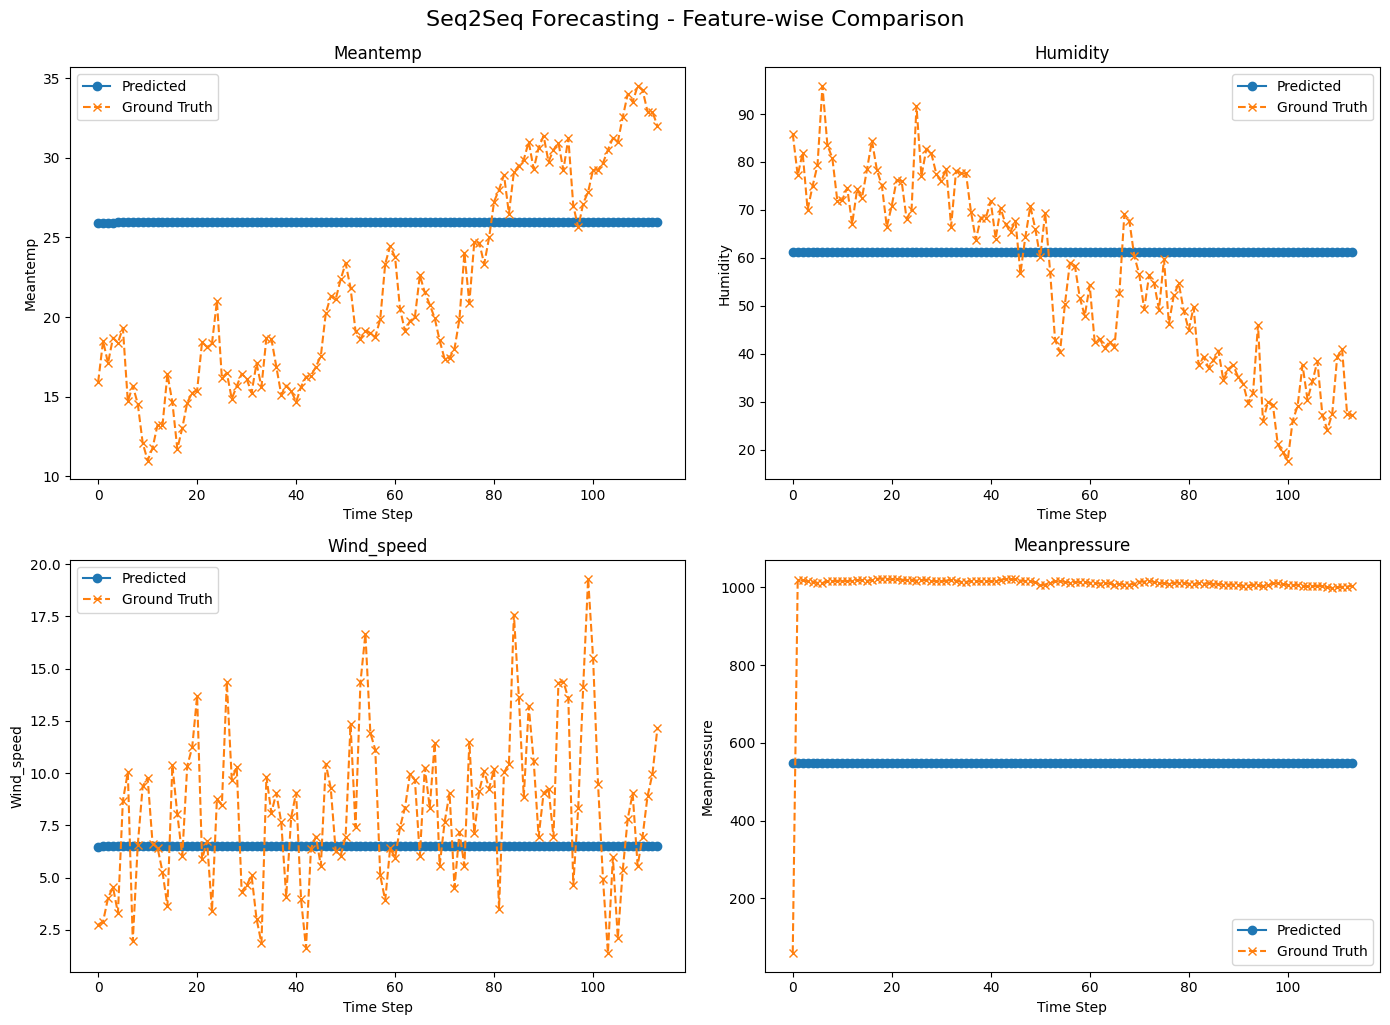

In [132]:
seq2seq_model.eval()
future_steps = 114

# Choose sample inputs from the end of the dataset
sample_input = torch.from_numpy(df_train[-366:])
print("sample input shape: ",sample_input)

sample_input = sample_input.unsqueeze(0)
print("sample input shape: ",sample_input.shape)

with torch.no_grad():
    predicted_output = seq2seq_model(sample_input, future_steps)
    print("predicted_output:", predicted_output)


# Convert to numpy for plotting
predicted_output = predicted_output.squeeze().cpu().numpy()
grouth_truth = data_test

# Plotting
import matplotlib.pyplot as plt

features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
num_features = len(features)
time_steps = predicted_output.shape[0]  # Should be 115

plt.figure(figsize=(14, 10))

for i in range(num_features):
    plt.subplot(2, 2, i + 1)
    
    # Plot predicted vs ground truth for each feature
    plt.plot(range(time_steps), predicted_output[:, i], label='Predicted', marker='o')
    plt.plot(range(time_steps), grouth_truth[:, i], label='Ground Truth', marker='x', linestyle='--')

    # Add labels and title using feature names
    plt.title(f'{features[i].capitalize()}')
    plt.xlabel('Time Step')
    plt.ylabel(features[i].capitalize())
    plt.legend()
    plt.tight_layout()

plt.suptitle("Seq2Seq Forecasting - Feature-wise Comparison", fontsize=16, y=1.02)
plt.show()
